In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 Physikalisch-Technische Bundesanstalt (PTB)
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:  Christoph Kolbitsch (PTB)

In [2]:
# Make sure figures appears inline
%matplotlib widget

# Dynamic MR Reconstruction

MR can be used to capture dynamic processes. These dynamic processes can be used to obtain information about quantitative (bio-)physical parameters. A common parameter important for clinical diagnosis is the longitudinal relaxation time $T_1$. In order to quantify $T_1$ a MR-preparation pulse is used (e.g. inversion pulse) to disturb the equilibrium state of the MR spin system. After the preparation pulse the spin system relaxes back to the equilibrium state and this dynamic process can be described by the relaxation time $T_1$. The dynamic acquisition after the preparation pulse therefore needs to be fast enough to capture the dynamic changes accurately. 

Here we are going to reconstruct images covering such a dynamic process. Data is acquired continuously using a Golden radial acquisition scheme and we are going to split this data into different time frames and then reconstruct this data as 2D+t data block. The motiviation for reconstructing one block, is that we can utilise regularisation between different time points to reduce undersampling artefacts.

Because we are going to do MR image reconstruction we also need SIRF for this.

The imaged object is a phantom which consists of 9 tubes with different types of gel in them. Each tube has a different $T_1$ time and hence the signal from each tube behaves differently over time.



### CIL Version 22.2.0
### SIRF Version 3.4.0

In [3]:
import cil
print(cil.__version__)
import sirf
print(sirf.__version__)

22.2.0
3.4.0


### The Dataset

This requires the dataset `egg2.zip` from https://zenodo.org/record/4822516:

- https://zenodo.org/record/4822516/files/egg2.zip?download=1


Please download the data and update the `filename` variable below to point to where you have the data saved:

In [4]:
filename = '/ck/data/dyn_grad/2D_Dyn_GRad.h5'

In [5]:
# import engine module
import sirf.Gadgetron as pMR

# import CIL functionality for visualisation and iterative reconstruction
from cil.utilities.jupyter import islicer
from cil.optimisation.algorithms import FISTA, PDHG
from cil.plugins.ccpi_regularisation.functions.regularisers import  RegulariserFunction
from cil.plugins.ccpi_regularisation.functions import  FGP_TV
from cil.optimisation.functions import LeastSquares, ZeroFunction, L2NormSquared

from cil.framework import  AcquisitionGeometry, BlockDataContainer, BlockGeometry, ImageGeometry, ImageData
from cil.optimisation.operators import GradientOperator, BlockOperator, ZeroOperator, CompositionOperator,LinearOperator

# import further modules
import os
import numpy as np
import time

import matplotlib.pyplot as plt

### Load and inspect the data

Let's load the data and have a look at the data acquisition over time.

In [6]:
# Load in the data
acq_data = pMR.AcquisitionData(filename)

Started reading acquisitions from /ck/data/dyn_grad/2D_Dyn_GRad.h5
0%..10%..20%..31%..40%..50%..61%..70%..80%..90%..
Finished reading acquisitions from /ck/data/dyn_grad/2D_Dyn_GRad.h5


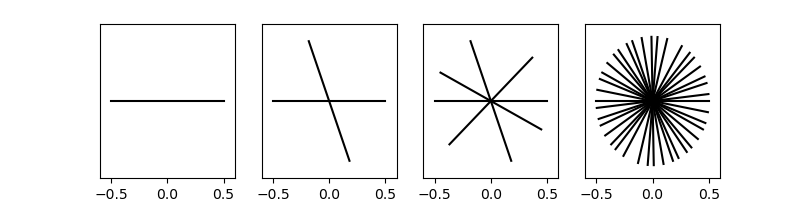

In [7]:
# Get k-space dimensions
kdim = acq_data.shape

# Get trajectory
ktraj = pMR.get_data_trajectory(acq_data)
ktraj = np.reshape(ktraj, (kdim[0], kdim[2], 2))

# Plot first 1,2,4 and 20 radial lines
plot_nrad = [1, 2, 4, 20]
fig, ax = plt.subplots(1,4,figsize=(8,2))
for cax in ax.flatten():
    cax.axis([-0.6, 0.6, -0.6, 0.6])
    cax.set_yticks([])
for jnd in range(4):
    for ind in range(plot_nrad[jnd]):
        ax[jnd].plot(ktraj[ind,:,0], ktraj[ind,:,1], 'k-')

Before we continue with the dynamic reconstruction we need to calculate the coil sensitivity maps. 

In [8]:
# Calculate coil sensitivity maps
csm = pMR.CoilSensitivityData()
csm.smoothness = 100
csm.calculate(acq_data)

### Prepare dynamic reconstruction

We are going to split the data into Ndyn dynamic frames each with `Nrad_per_dyn` radial lines. We chose `N_dyn` small here to speed things up and won't be using all the data but feel free to adapt this.

In [9]:
# Parameters for dynamics
Ndyn = 12
Nrad_per_dyn = 16

Now we are going to select the data `acq_data` and define the acquisition model `E_dyn` for each dynamic. A preliminary (i.e. pseudo-inverse) reconstruction can be found in `im_dyn_inv`.

In [10]:
# Go through each dynamic, create corresponding k-space and acquisition model
acq_dyn = [0] * Ndyn
E_dyn = [0] * Ndyn
im_dyn_inv = [0] * Ndyn

for ind in range(Ndyn):
    acq_idx_dyn = np.linspace(ind*Nrad_per_dyn, (ind+1)*Nrad_per_dyn-1, Nrad_per_dyn)
    acq_dyn[ind] = acq_data.get_subset(acq_idx_dyn) 
    acq_dyn[ind].sort_by_time()
        
    # Create acquisition model
    E_tmp = pMR.AcquisitionModel(acqs=acq_dyn[ind], imgs=csm)
    E_tmp.set_coil_sensitivity_maps(csm)
    im_dyn_inv[ind] = E_tmp.inverse(acq_dyn[ind])

    E_dyn[ind] = pMR.AcquisitionModel(acqs=acq_dyn[ind], imgs=im_dyn_inv[ind])
    E_dyn[ind].set_coil_sensitivity_maps(csm)

In order to be able to reconstruct all the dynamics at the same time, we have to create a diagonal matrix with all the acquisition models along the diagonal and zero-operators everywhere else. The problem we want to solve in the end is:

$$
\min_{[x_0\cdots x_{NDyn}]^T} \left\Vert \begin{bmatrix}
    E_0 & 0 & 0\\
    0 & \ddots & 0 \\
    0 & 0 & E_{NDyn}
  \end{bmatrix} 
  \begin{bmatrix}
    x_0 \\
    \vdots \\
    x_{NDyn}
  \end{bmatrix} - 
  \begin{bmatrix}
    a_0 \\
    \vdots \\
    a_{NDyn}
  \end{bmatrix}
  \right\Vert_2^2
$$

  where $a$ is `acq_data`, $E$ is `E_dyn` and $x$ are the reconstructed dynamic images.

In [11]:
# AcquisitionModel for each dynamic

# Create zero operator
ZOp = ZeroOperator(E_dyn[0].domain_geometry(), E_dyn[0].range_geometry())

E_dyn_diag = [ZOp,]*(Ndyn*Ndyn)
for ind in range(Ndyn):
    E_dyn_diag[ind*Ndyn+ind] = E_dyn[ind]
    
A = BlockOperator(*E_dyn_diag, shape=(Ndyn, Ndyn))

# Put together all the raw k-space data for each motion state in a BlockDataContainer
acq_dyn_block = BlockDataContainer(*acq_dyn)

# Starting image
x_init = A.adjoint(acq_dyn_block)

### Dynamic reconstruction without regularisation

In [12]:
# Set up optimisation
x_init_zero = x_init.copy()
x_init_zero.fill(0.0)

# Objective function
f = LeastSquares(A, acq_dyn_block, c=1)
f.calculate_Lipschitz()
G = ZeroFunction()

# Set up FISTA for least squares
fista = FISTA(initial=x_init_zero, f=f, g=G)
fista.max_iteration = 30
fista.update_objective_interval = 10

# Run FISTA
fista.run(verbose=True)

# Get result
im_fista = fista.get_output()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         30         0.000          8.05277e-03


### Dynamic reconstruction with TV regularisation

In order to add TV-regularisation we need a bit of code which handles the diagonal structure of our image reconstruction problem. The main idea is to take the block data container and transform it into a 3d image, i.e. translate the "block-dimension" into the "channel-dimension" of a single image. Then we can apply the TV operator and afterwards we split it up again into different blocks. The code is found in `tv_for_bdc.py` so we simply import it.

In [ ]:
import sys
sys.path.append('CIL-User-Showcase/dynamic_mr_recon/')
from tv_for_bdc import FGP_TV_BDC

In [ ]:
# Set up optimisation
x_init_zero = x_init.copy()

# Objective function
f = LeastSquares(A, acq_dyn_block, c=1)
f.calculate_Lipschitz()

alpha = 2e-6
G = FGP_TV_BDC(x_init_zero, alpha)

# Set up FISTA for least squares
fista = FISTA(initial=x_init_zero, f=f, g=G)
fista.max_iteration = 30
fista.update_objective_interval = 10

# Run FISTA
fista.run(verbose=True)

# Get result
im_fista_tv = fista.get_output()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     


/opt/SIRF-SuperBuild/INSTALL/python/cil/plugins/ccpi_regularisation/functions/regularisers.py:118: ComplexWarning: Casting complex values to real discards the imaginary part
  in_arr = np.asarray(x.as_array(), dtype=np.float32, order='C')


        0        100         0.000          5.34803e-03
       10        100         1.239          1.45425e-05
       20        100         1.222          9.42852e-06
       30        100         1.230          9.30631e-06
       40        100         1.253          9.28251e-06
-------------------------------------------------------
       40        100         1.253          9.28251e-06
Stop criterion has been reached.



### Visualise results

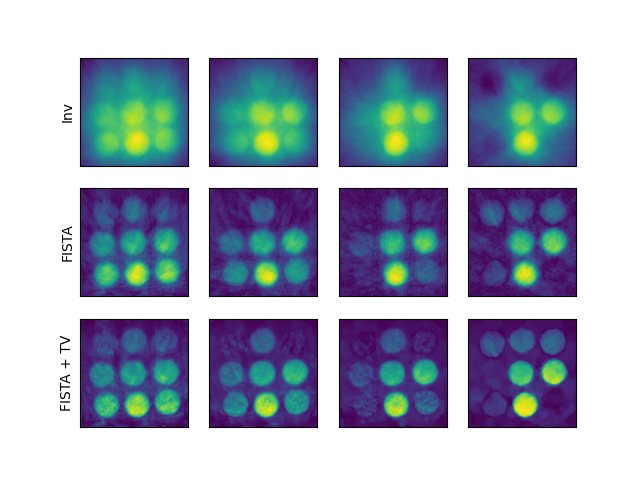

In [ ]:
# List of images to 2D+t matrix
im_list = [im_dyn_inv, im_fista, im_fista_tv]
im_2dt = []
for ind in range(len(im_list)):
    cim = []
    for jnd in range(len(im_list[ind])):
        cim.append(np.abs(np.squeeze(im_list[ind][jnd].as_array())))
    print(cim[0].shape)
    im_2dt.append(np.concatenate(cim, axis=5))

# Normalise images
for ind in range(len(im_2dt)):
    im_2dt[ind] = (im_2dt[ind] - np.min(im_2dt[ind]))/(np.max(im_2dt[ind]) - np.min(im_2dt[ind]))

# Plot images
nplots = max(Ndyn, 6)
fig, ax = plt.subplots(len(im_2dt), nplots)
for cax in ax.flatten():
    cax.set_xticks([])
    cax.set_yticks([])
for ind in range(nplots):
    cidx = int(ind / nplots * Ndyn)
    for jnd in range(len(im_2dt)):
        ax[jnd,ind].imshow(im_2dt[jnd][:,:,cidx], vmin=0, vmax=1.0)

    if ind == 0:
        ax[0,ind].set_ylabel('Inv')
        ax[1,ind].set_ylabel('FISTA')
        ax[2,ind].set_ylabel('FISTA + TV')